For this notebook to work from start to end without needing to change and directories, ensure that the folder FINAL_RNA/ is in our github folder chrisnatjulia/ and this notebook is in our github folder chrisnatjulia/scripts/graphs_for_assembly_in_R

In [1]:
library(dplyr)
library(data.table)
library(ggplot2)
library(viridis)
library(vegan)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: viridisLite

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [2]:
##### Set parameters
# Indicate assemblers, classifiers, and mappers you used
assemblers <- c("IDBA-tran", "rnaSPAdes", "Trinity")
classifiers <- c("BLAST_nt", "BLAST_SILVA", "CREST")
mappers <- c("Bowtie2", "BWA")

# 1. Read in data and tidy it up

In [3]:
# Reading in data from all files in folder
files_list_full_path <- list.files("../../FINAL_RNA/", pattern = "\\.txt$", , full.names=T) # For fread to work (needs full path in our case)
files_list_just_names <- list.files("../../FINAL_RNA/", pattern = "\\.txt$") # To make names for the dataframes based on file names
dataframe_names_list <- gsub("\\_final.txt$", "", files_list_just_names)
all_list <- lapply(files_list_full_path, fread) # Creating a list with data frames of all files
names(all_list) <- dataframe_names_list # Changing the names of the dataframes in list
tax_full_dataframes <- lapply(all_list, function(x) x%>% select(superkingdom:genus)) # Creating a list with full taxanomy of each data frame
counts_dataframes <- lapply(all_list, function(x) x%>% select(counts)) # Creating a list with counts of each data frame


In [4]:
# Create function to create taxlist vector with phylum per row in taxonomy table (or if phylum = NA, then superkingdom: Unkown)
make_tax_phylum_dataframe <- function(tax)
  {
    taxlastrow <- nrow(tax)
    taxlist <- rep(NA,nrow(tax))
    for (i in 1:nrow(tax))
    { if (is.na(tax[i,1]) == TRUE)
      { taxlist[i] <- "NA"
    } else if (tax[i,1] == "Unknown")
      { taxlist[i] <- "Unknown"
    } else if (is.na(tax[i,3]) == TRUE)
      { taxlist[i] <- paste(tax[i,1], ": Unknown", sep="")
    } else
      { taxlist[i] <- paste(tax[i,1], ": ", tax[i,3], sep="") }
    }
    taxdf <- as.data.frame(taxlist)
    return(taxdf)
  }

# Create function to create taxlist vector with superkingdom per row in taxonomy table
make_tax_superkingdom_dataframe <- function(tax)
{
  taxlastrow <- nrow(tax)
  taxlist <- rep(NA,nrow(tax))
  for (i in 1:nrow(tax))
  { if (is.na(tax[i,1]) == TRUE)
      { taxlist[i] <- "NA"
      } else
      { taxlist[i] <- tax[i,1] }
  }
  taxdf <- t(as.data.frame(taxlist))
  return(taxdf)
}

In [5]:
# Apply taxlist fuction to list of dataframes (phylum and superkingdom assignments in separate dataframe lists)
tax_superkingdom_dataframes <- lapply(tax_full_dataframes, make_tax_superkingdom_dataframe)
tax_phylum_dataframes <- lapply(tax_full_dataframes, make_tax_phylum_dataframe)

In [6]:
# Combine read count and phylum/superkingdom information and aggregate based on groups
aggregate_tax_groups <- function(group_counts_dataframes)
  {
    setNames(aggregate(unlist(group_counts_dataframes[[2]])~unlist(group_counts_dataframes[[1]]),data=group_counts_dataframes,FUN=sum), c("Group", "Reads"))
  }

phylum_counts_dataframes <- mapply(cbind, tax_phylum_dataframes, counts_dataframes, SIMPLIFY=FALSE)
phylum_agg_dataframes <- lapply(phylum_counts_dataframes, aggregate_tax_groups)

superkingdom_counts_dataframes <- mapply(cbind, tax_superkingdom_dataframes, counts_dataframes, SIMPLIFY=FALSE)
superkingdom_agg_dataframes <- lapply(superkingdom_counts_dataframes, aggregate_tax_groups)

In [7]:
# Merge all dataframes in list
## for phylum
merged_phylum <- phylum_agg_dataframes %>%
  Reduce(function(df1,df2) full_join(df1,df2,by="Group"), .) %>% 
  mutate_each(funs(replace(., which(is.na(.)), 0)))
colnames(merged_phylum) <- c("Group", dataframe_names_list)
merged_phylum_ordered <- merged_phylum[order(as.character(merged_phylum$Group)),] # Order groups alphabetically
merged_phylum_ordered$Group <- factor(merged_phylum_ordered$Group, levels=merged_phylum_ordered$Group) # Command to keep order for ggplot2
         
## for superkingdom
merged_superkingdom <- superkingdom_agg_dataframes %>%
  Reduce(function(df1,df2) full_join(df1,df2,by="Group"), .) %>% 
  mutate_each(funs(replace(., which(is.na(.)), 0)))
colnames(merged_superkingdom) <- c("Group", dataframe_names_list)
merged_superkingdom_ordered <- merged_superkingdom[order(as.character(merged_superkingdom$Group)),] # Order groups alphabetically
merged_superkingdom_ordered$Group <- factor(merged_superkingdom_ordered$Group, levels=merged_superkingdom_ordered$Group) # Command to keep order for ggplot2

Warning message:
“Column `Group` joining factors with different levels, coercing to character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing into character vector”
Warning message:
“Column `Group` joining character vector and factor, coercing int

In [8]:
# Generate relative abundances
## for phylum
phylum_relative_abundances_only <- merged_phylum_ordered
phylum_relative_abundances_only[,1] <- NULL # Delete column Group
phylum_relative_abundances_only <- decostand(phylum_relative_abundances_only, "total", 2)
phylum_relative_abundances <- cbind(merged_phylum_ordered$Group, decostand(phylum_relative_abundances_only, "total", 2))
colnames(phylum_relative_abundances) <- c("Group", dataframe_names_list)

## for superkingdom
superkingdom_relative_abundances_only <- merged_superkingdom_ordered
superkingdom_relative_abundances_only[,1] <- NULL # Delete column Group
superkingdom_relative_abundances_only <- decostand(superkingdom_relative_abundances_only, "total", 2)
superkingdom_relative_abundances <- cbind(merged_superkingdom_ordered$Group, decostand(superkingdom_relative_abundances_only, "total", 2))
colnames(superkingdom_relative_abundances) <- c("Group", dataframe_names_list)

# 2. Prepare data for plotting

Set color for plots (Note: colorvec2 and colorvec3 have a limited number of colors and don't work for graphs with large number of groups (i.e., datasets with phylum assigned)

In [9]:
# Transform dataset for stacked barplots
phylum_melted <- reshape2::melt(phylum_relative_abundances,id.vars = "Group", variable.name="Combination", value.name="Reads")
superkingdom_melted <- reshape2::melt(superkingdom_relative_abundances,id.vars = "Group", variable.name="Combination", value.name="Reads")

In [10]:
# Generate Assembler, Classifier, and Mapper columns for the different combinations in melted dataset

# Generate assembler column
make_assembler_column <- function(groups_melted)
{
    assembler_column <- NULL 
    for (i in 1:number_of_assemblers) 
    {
      loopresult <- rep(assemblers[i], nrow(groups_melted)/number_of_assemblers)
      assembler_column <- c(assembler_column,loopresult)
    }
return(assembler_column)
}

# Generate classifier column
make_classifier_column <- function(groups_melted)
{
    classifier_column <- NULL
    rep_classifier <- 1
    while (rep_classifier<number_of_assemblers+1)
    {
      for (i in 1:number_of_classifiers) 
      {
        loopresults <- rep(classifiers[i], nrow(groups_melted)/number_of_assemblers/number_of_classifiers)
        classifier_column <- c(classifier_column,loopresults)
      }
    rep_classifier <- rep_classifier+1
    }
return(classifier_column)
}

# Generate mapper column
make_mapper_column <- function(groups_melted)
{
    mapper_column <- NULL
    rep_mapper <- 1
    while (rep_mapper<number_of_assemblers*number_of_classifiers+1)
    {
      for (i in 1:number_of_mappers)
      {
        loopresults <- rep(mappers[i], nrow(groups_melted)/number_of_assemblers/number_of_classifiers/number_of_mappers)
        mapper_column <- c(mapper_column,loopresults)
      }
      rep_mapper <- rep_mapper+1
    }
return(mapper_column)
}

In [12]:
# Attach new columns to groups_melted
number_of_assemblers <- length(assemblers)
number_of_classifiers <- length(classifiers)
number_of_mappers <- length(mappers)

## for phylum
assembler_column_phylum <- make_assembler_column(phylum_melted)
classifier_column_phylum <- make_classifier_column(phylum_melted)
mapper_column_phylum <- make_mapper_column(phylum_melted)

phylum_melted$Assembler <- assembler_column_phylum
phylum_melted$Classifier <- classifier_column_phylum
phylum_melted$Mapper <- mapper_column_phylum

## for superkingdom
assembler_column_superkingdom <- make_assembler_column(superkingdom_melted)
classifier_column_superkingdom <- make_classifier_column(superkingdom_melted)
mapper_column_superkingdom <- make_mapper_column(superkingdom_melted)

superkingdom_melted$Assembler <- assembler_column_superkingdom
superkingdom_melted$Classifier <- classifier_column_superkingdom
superkingdom_melted$Mapper <- mapper_column_superkingdom

# 3. Plot data

In [13]:
phylum_viridis_colors <- viridis_pal(option = "D")(nrow(phylum_relative_abundances)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002)
colorvec_phylum <- sample(phylum_viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish

superkingdom_viridis_colors <- viridis_pal(option = "D")(nrow(superkingdom_relative_abundances)) # Choosing viridis colors (colorblindfriendly), as many colors from gradient as numbers of groups
set.seed(002)
colorvec_superkingdom <- sample(superkingdom_viridis_colors) # Randomize color order, otherwise bars next to each other are hard to distinguish

#colorvec2 <- c("#023fa5", "#7d87b9", "#bec1d4", "#d6bcc0", "#bb7784", "#8e063b", "#11c638", "#8dd593", "#c6dec7", "#ead3c6", "#f0b98d", "#ef9708", "#0fcfc0", "#9cded6", "#d5eae7", "#f3e1eb", "#f6c4e1", "#f79cd4", "#4a6fe3", "#8595e1", "#b5bbe3", "#e6afb9", "#e07b91", "#d33f6a")
#colorvec3 <- c("#72d5de","#eca9b0","#7fe1cf","#e1b0dd","#aad9a7","#74aff3","#c6d494","#b9b5f3","#ebc491","#7bc2f1","#dac6a3","#8bd0eb","#94dcba","#b6bee4","#acd8ba","#86bcb1","#afe6db")

## 3.1 Plot data assigned to superkingdoms

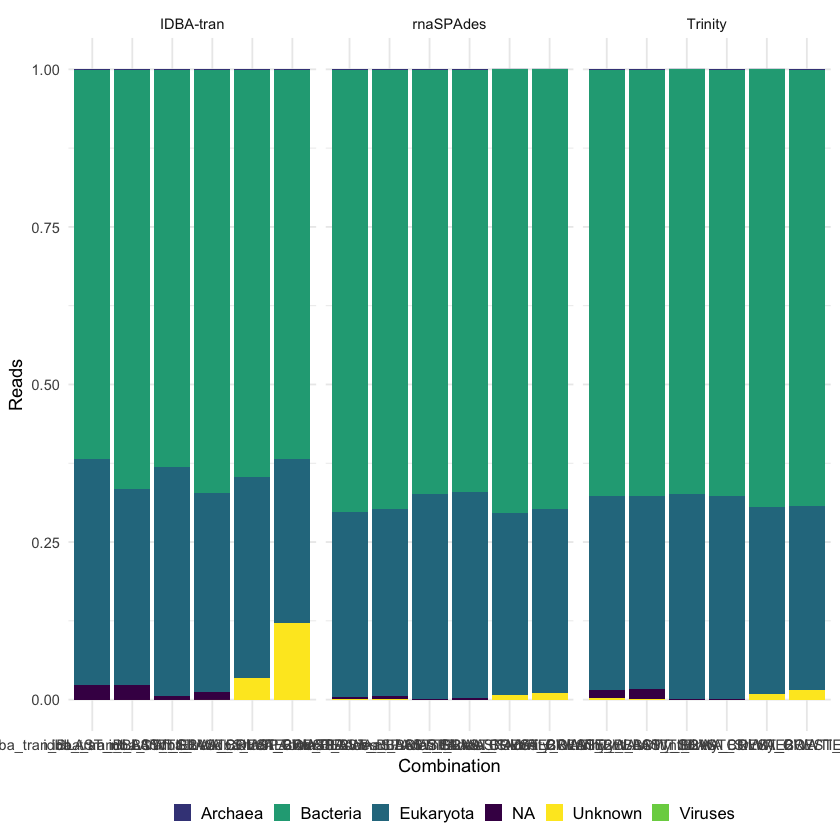

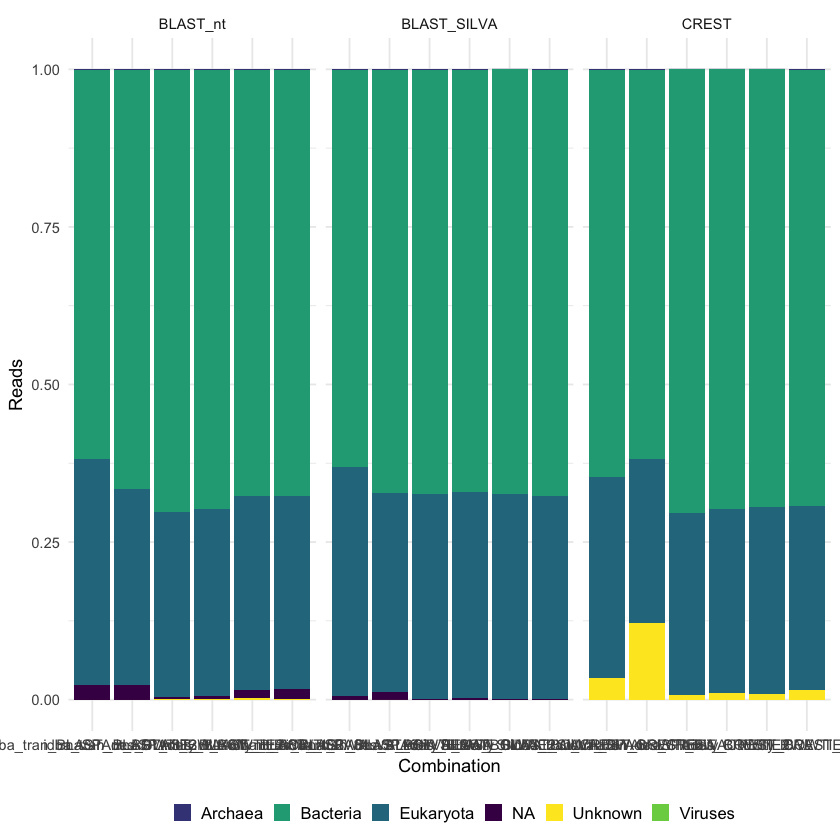

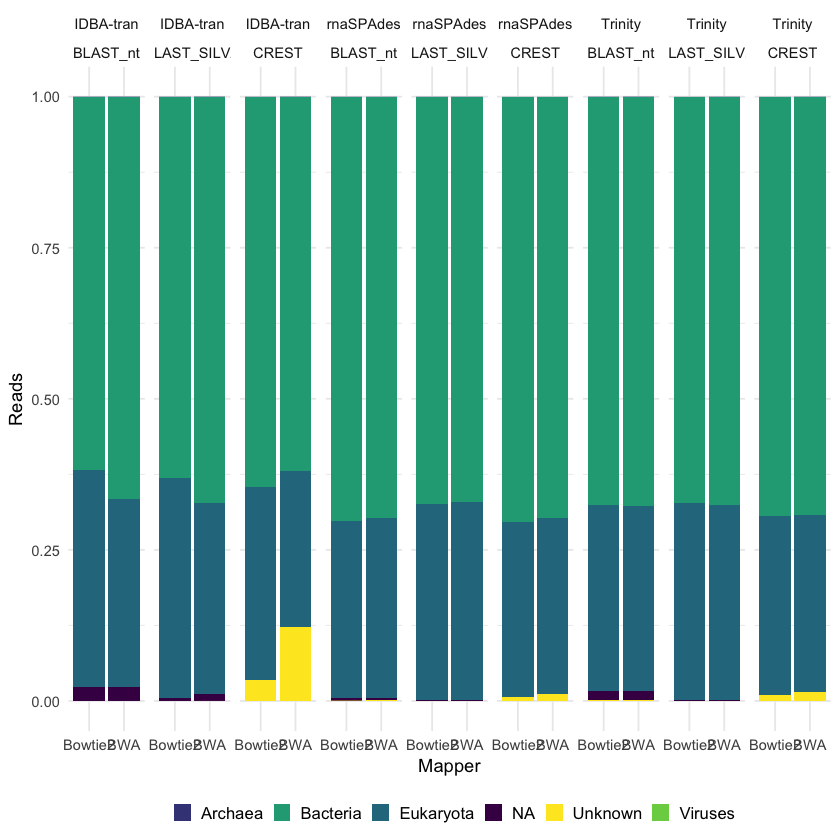

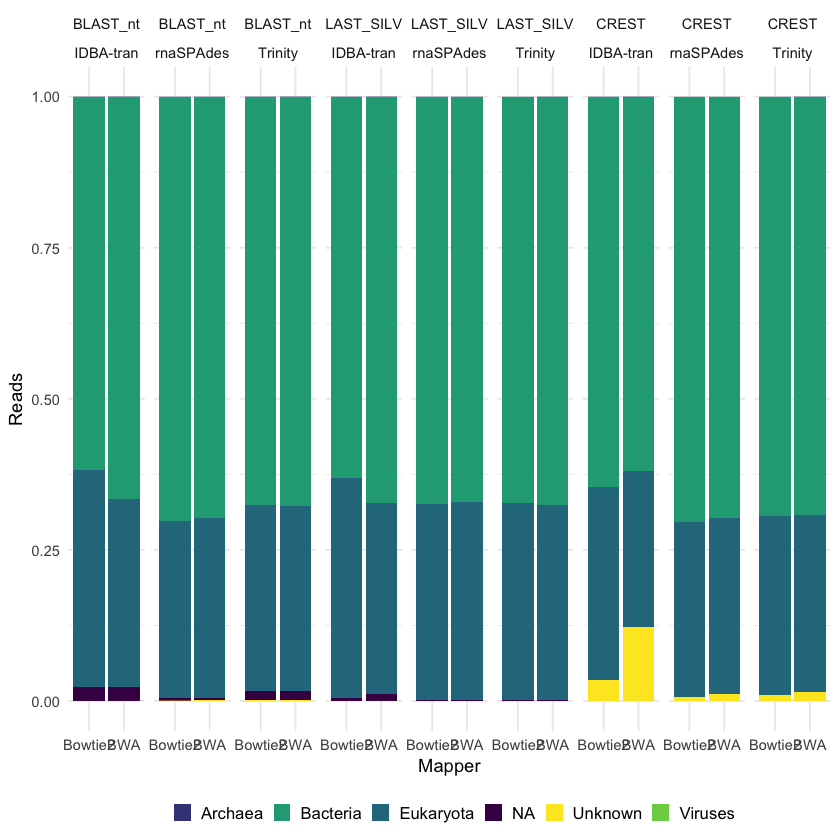

In [14]:
# Plot grouped by assembler
plot2<-ggplot(superkingdom_melted, aes(x = Combination, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
  # facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
plot2
#ggsave("Plot2.png", plot=plot2,  device="png",  width=240, units="mm")

# Plot grouped by classifier
plot3<-ggplot(superkingdom_melted, aes(x = Combination, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
  # facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
plot3
#ggsave("Plot3.png", plot=plot3,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot4<-ggplot(superkingdom_melted, aes(x = Mapper, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
# facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
plot4
#ggsave("Plot4.png", plot=plot4,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot5<-ggplot(superkingdom_melted, aes(x = Mapper, y = Reads, fill = Group))+
  #geom_bar(stat = 'identity', position = 'stack', colour="black")+
  geom_bar(stat = 'identity', position = 'stack')+
# facet_grid(Assembler ~ Classifier, scales = "free", space = "free")+
  facet_grid( ~ Classifier + Assembler , scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_superkingdom)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=6,byrow=FALSE))
plot5
#ggsave("Plot5.png", plot=plot5,  device="png",  width=240, units="mm")


## 3.2 Plot data assigned to phylum

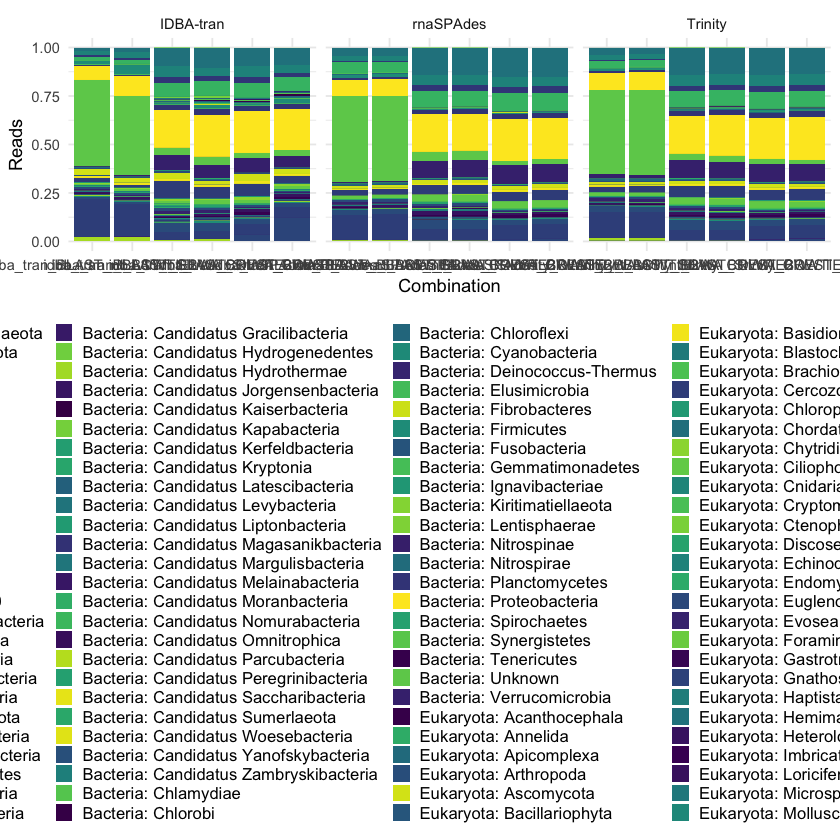

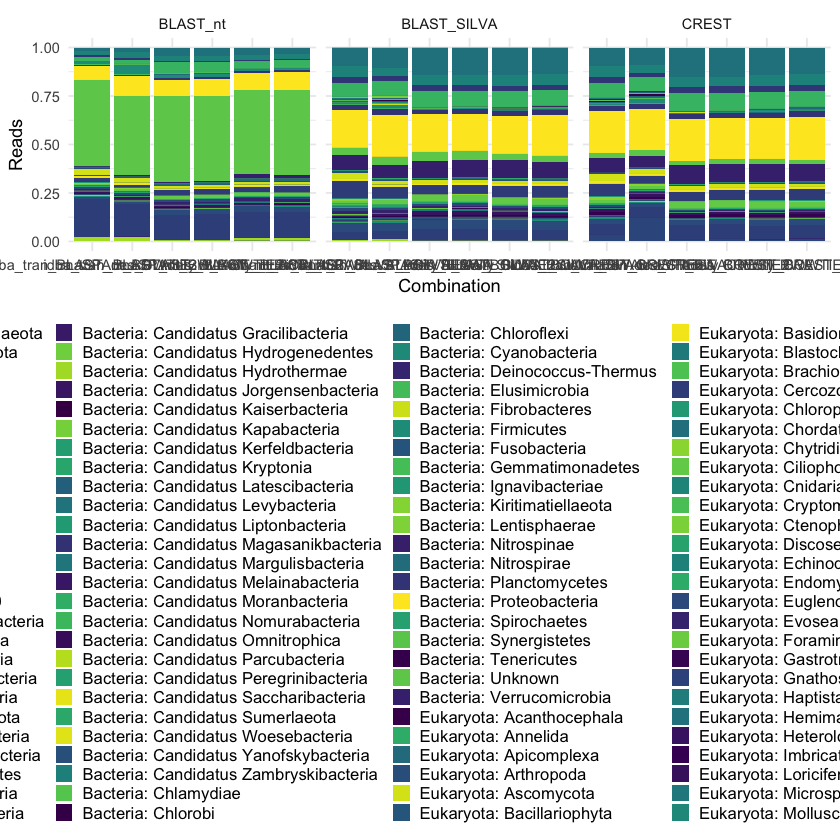

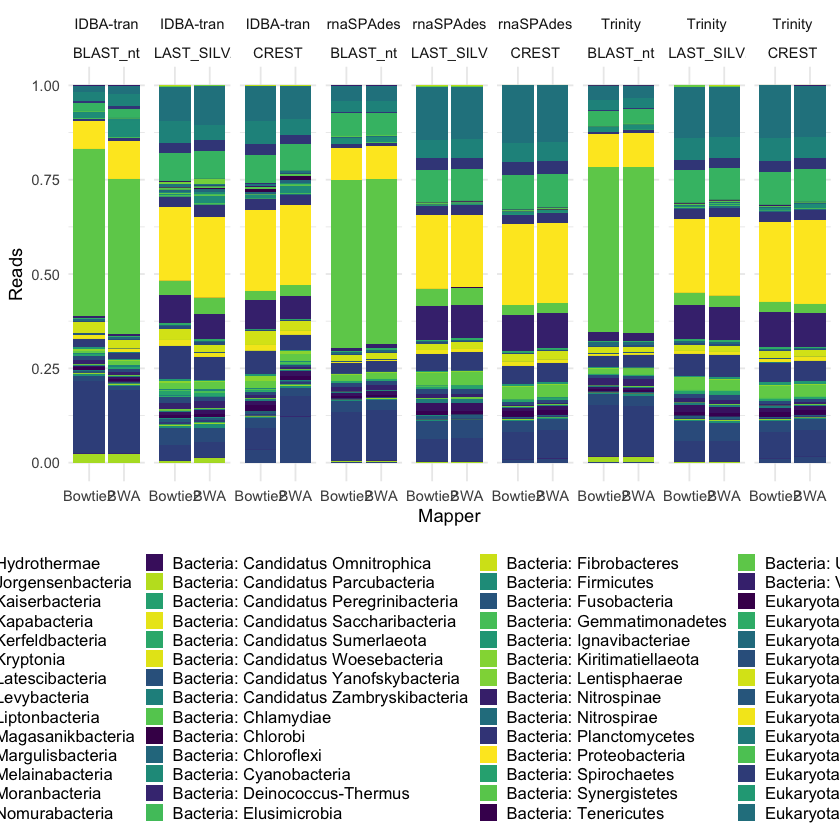

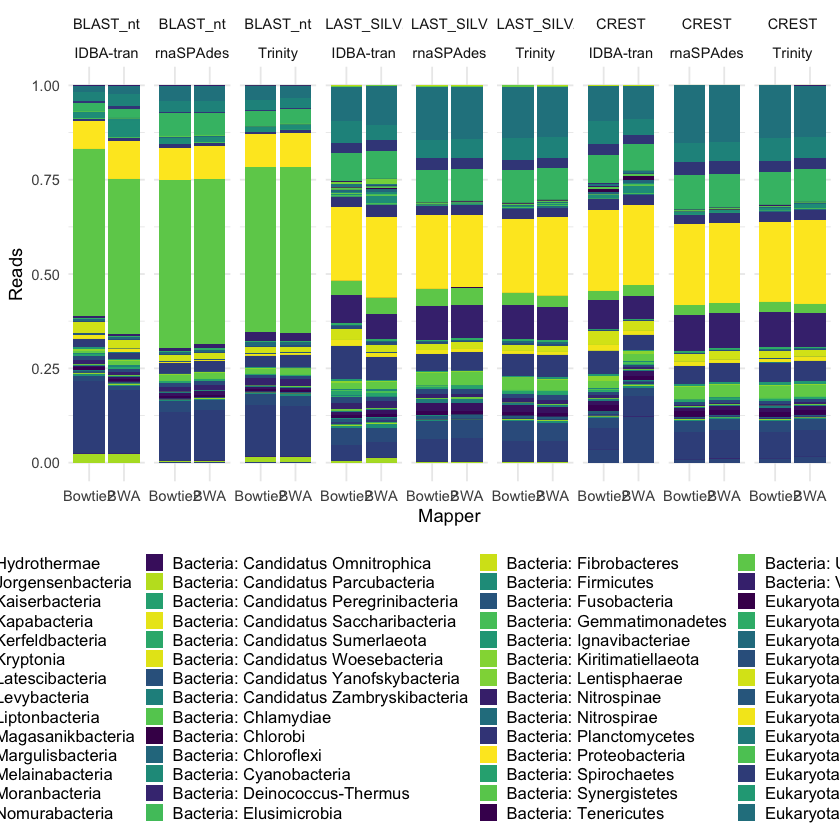

In [15]:
# Plot grouped by assembler
plot6<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())
plot6
#ggsave("Plot6.png", plot=plot6,  device="png",  width=240, units="mm")

# Plot grouped by classifier
plot7<-ggplot(phylum_melted, aes(x = Combination, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())
plot7
#ggsave("Plot7.png", plot=plot7,  device="png",  width=240, units="mm")

# Plot grouped by assembler and classifier
plot8<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Assembler + Classifier, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=9,byrow=FALSE))
plot8
#ggsave("Plot8.png", plot=plot8,  device="png",  width=240, units="mm")

# Plot grouped by classifier and assembler
plot9<-ggplot(phylum_melted, aes(x = Mapper, y = Reads, fill = Group))+
  geom_bar(stat = 'identity', position = 'stack')+
  facet_grid( ~ Classifier + Assembler, scales = "free", space = "free")+
  theme_minimal()+
  scale_fill_manual(values=colorvec_phylum)+
  theme(legend.key.size = unit(0.8,"line"))+
  theme(legend.position="bottom")+
  theme(legend.text=element_text(size=10))+
  theme(legend.title=element_blank())+
  guides(fill=guide_legend(ncol=9,byrow=FALSE))
plot9
#ggsave("Plot9.png", plot=plot9,  device="png",  width=240, units="mm")

In [16]:
# Subsetting merged_ordered for PHYLUM that are of low abundance (rowSums < abundance)

minimum_abundance <- 100
merged_phylum_ordered_subset <- merged_phylum_ordered
rownames(merged_phylum_ordered_subset) <- merged_phylum_ordered_subset$Group
merged_phylum_ordered_subset$Group <- NULL
merged_phylum_ordered_subset <- subset(merged_phylum_ordered_subset, rowSums(merged_phylum_ordered_subset) >= minimum_abundance)
